# MLIP and Espresso
In this tutorial, you'll learn how to train and deploy a machine-learned interatomic potential (MLIP) with espresso.
We'll be using the [apax](https://github.com/apaxhub/apax) MLIP. (https://pubs.acs.org/doi/full/10.1021/acs.jcim.5c01221)

In the tutorial for MD part, all physical parameters constituting the system follow those used in the system constructed in the tutorial for evaluating the MLIPs. Hence, we need to read them from **water.json** file.

In [1]:
from ase.io import read
import zntrack

box = read('water.json')

We also need to define the model used in MD to suite your task requirements.

**Exercise:**
- Create the model by `zntrack.from.rev(String)` to suite your task requirements.

**Hint:**
- The argument for `zntrack.from.rev` can be accepted for following string: `r_max_2_Apax`, `r_max_3_Apax`, `r_max_4_Apax`, `r_max_5_Apax`, `r_max_6_Apax`.

In [2]:
#Solution
model = zntrack.from_rev("r_max_5_Apax")

By using generated `model.get_calculater()`, we can obtain trained interaction calculater `calc`.

In [3]:
calc = model.get_calculator()

box.calc = calc

/tikhome/hkobayashi/.env/tutotial_2025_mlip/lib/python3.12/site-packages/zntrack/state.py:159: UserWarning: The temporary path is not used when neither remote or rev are set.Consider checking for `self.state.remote` and `self.state.rev` whenusing `with node.state.use_tmp_path(): ...` .
  warnings.warn(


## MD simulations with MLIP by ESPResSo
Here, we import the necessary ESPResSo features and external modules to combine ESPResSo with MLIP

In [4]:
# ESPResSo imports
import espressomd
from espressomd.plugins.ase import ASEInterface
from espressomd.zn import Visualizer

# Miscellaneous
import pint
import tqdm

### Unit
In the majority of studies employing machine-learned interatomic potentials, energies are expressed in electronvolts (eV), distances in angstroms, and masses in atomic units. This convention does not arise from limitations of the models, but rather reflects the de facto standard that has emerged. Although machine-learning algorithms are agnostic to the choice of units, they must be trained within a consistent unit system; thus, it is essential to identify the units being used. Temporal scales are commonly expressed in femtoseconds. Consistent with this practice, ASE adopts the same unit system as its default. In the present tutorial, we employ pint to manage units.

**Exercise:**
- Create an instance of the [`pint.UnitRegistry`](https://pint.readthedocs.io/en/stable/api/base.html#pint.UnitRegistry) for the unit conversions throughout the tutorial and name the variable `ureg`.

**Hint:**
- It might be helpful to look at the [Tutorial section of pint](https://pint.readthedocs.io/en/stable/getting/tutorial.html#initializing-a-registry).

In [5]:
#Solution
ureg = pint.UnitRegistry()

### Setup System for ESPResO
All parameters, i.e, system size, the number of particles, the particle positions and etc., are followed to `box` from ASE. For simplicity, the type of each particle is defined as the atomic number of them.

In [6]:
system = espressomd.System(box_l=box.get_cell().diagonal())
system.periodicity = [True, True, True]
system.time_step = (1.0 * ureg.fs).m_as(((1 * ureg.u * ureg.angstrom**2) / ureg.electron_volt) ** 0.5)
print(system.time_step)
system.cell_system.skin = 0.4
system.part.clear()
for atom in box:
    system.part.add(pos=atom.position, type=atom.number, mass=atom.mass)

0.09822694743391454


To combine ESPResSo and MLIP provided by ASE, we use `espressomd.plugins.ase.ASEInterface`. The arguments of constuctor for `espressomd.plugins.ase.ASEInterface` are `espressomd.System system`, `dictionary type_mapping` and `espressomd.system.part particle_slice`.


ESPResSo can deal with fictitious particle types, does not require physically realistic particle numbers. By contrast, ASE only deals with atomic number. Because of this, we have to define the mapping between the ESPResSo particle types and the ASE atom types. This is done by passing a type_mapping dictionary to the ASEInterface class. An example for such a type map for a water system would be:
An example for such a type map for a water system would be:

type_mapping = {1: 8, 2: 1}

e.g., particle type 1 in ESPResSo is mapped to Oxygen (atomic number 8) and particle type 2 is mapped to Hydrogen (atomic number 1).

In this tutorial, for simplicity, we already set the same particle types as the atomic number in ASE.

**Exercise:**
- Create dictionry `type_mapping` to correctoly maps between ASE and ESPResSo according to the current setting. 

**Hint:**
- The system contains only hydrogen(atomic number 1) and oxygen(atomic number 8).

In [7]:
#Solution
type_mapping={x: x for x in set(box.numbers)}

Using this `type_mapping`, we create `espressomd.plugins.ase.ASEInterface ase_interface`.

In [8]:
ase_interface = espressomd.plugins.ase.ASEInterface(
    system=system,
    type_mapping=type_mapping,
    particle_slice=system.part.all()
)

### Steepest Descent
We use steepset descent to minimize the energy of the system.

In [9]:
system.integrator.set_steepest_descent(f_max=(0.1 * ureg.eV / ureg.angstrom).magnitude,
                                       gamma=4,
                                       max_displacement=(0.001 * ureg.angstrom).magnitude)

MD integration can be perfomed by `ase_interface.integrate(steps: int, calculator)`. steps means the number of integration steps to perform.

For each step:
1. Update ASE with current particle data
2. Get forces from calculator
3. Set external forces on particles
4. Run one integration step

**Exercise:**
- Integrate the sytem for 500 steps in total. 

**Hint:**
- the argument `calculater` should be trained interaction calculater `box.calc`.

In [10]:
#Solution
tbar = tqdm.trange(1000, ncols=120)
for _ in tbar:
    ase_interface.integrate(1, box.calc)
    tbar.set_description(f"E_pot: {ase_interface.atoms.get_potential_energy():.3f} eV")

E_pot: -46940.656 eV: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.98it/s]


### Equilibration
Then, we turn on the Langevin thermostat and run a warmup integration by simplectic Euler algorithm. Here we set the temperature as **298.15** K.

In [11]:
#Symplectic Euler with Langevin Thermostat
system.thermostat.set_langevin(kT=(298.15 * ureg.K * ureg.boltzmann_constant).m_as("eV"), gamma=2, seed=42)
system.integrator.set_symplectic_euler()

In [12]:
tbar = tqdm.trange(5000, ncols=120)
for idx in tbar:
    ase_interface.integrate(1, box.calc)
    tbar.set_description(f"E_pot: {ase_interface.atoms.get_potential_energy():.3f} eV")

E_pot: -46936.413 eV: 100%|█████████████████████████████████████████████████████████| 5000/5000 [00:56<00:00, 88.58it/s]


### Sampling of radial distribution function (RDF)
After warmup calculation, we accumrate the radial distribution function (rdf) of oxygen-oxgen and plot them.

In [13]:
import espressomd.observables

rdfs = []
rdf_bins = 700
r_min = 0.0
r_max = 7  # angstrom
o_ids = system.part.select(type=8).id
rdf_obs = espressomd.observables.RDF(
    ids1=o_ids, ids2=o_ids, n_r_bins=500, min_r=r_min, max_r=r_max)

# Sampling of RDF
import numpy as np
tbar = tqdm.trange(100, ncols=120)
for idx in tbar:
    ase_interface.integrate(5, box.calc)
    rdfs.append(rdf_obs.calculate())
rdf = np.mean(rdfs, axis=0)
rdf_err = np.std(rdfs, axis=0)/np.sqrt(len(rdfs))
bin_centers = rdf_obs.bin_centers()

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.59it/s]


### Plot RDF
Since Van der waals radius of oxygen is 1.5 angstrom, the first peak in RDF should be arund 3. Due to the tetrahedral structure of water at 298.15 K, the second peak in RDF should appears at about 1.5-1.6 times the Van der waals diamter, corresponding to a distance of approximately 4.5-4.8 angstrome.

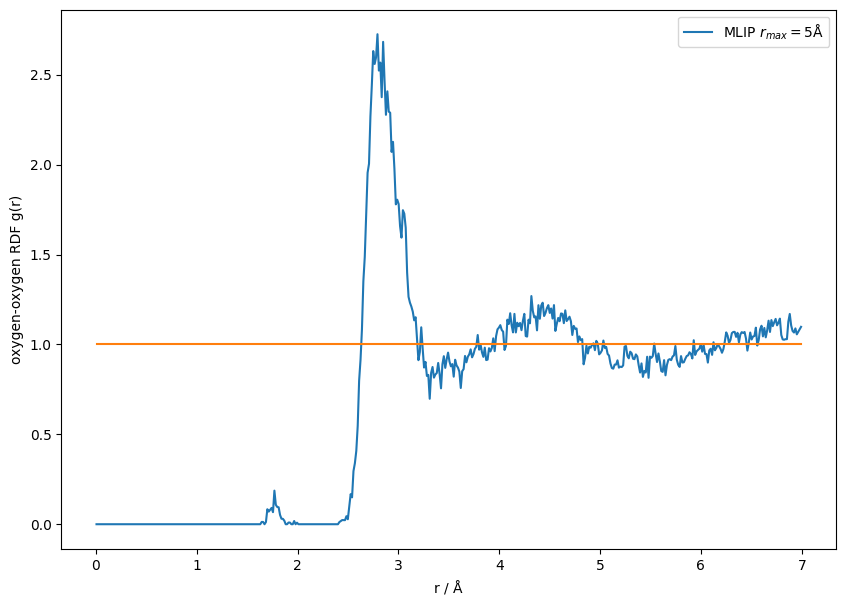

In [14]:
# Plot RDF
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(bin_centers, rdf, label=r'MLIP $r_{max}= 5\mathrm{\AA}$')
ax.plot(bin_centers, np.ones(bin_centers.size))
plt.legend()
plt.xlabel(r'r / $\mathrm{\AA}$')
plt.ylabel('oxygen-oxygen RDF g(r)')
plt.show()

Exercise

Comparison between RDF obtainded from atomistic simulations and that obtained using MLIP.